In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import random
import itertools
import os

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# keras Model.history 손실 출력
def plt_loss(history):
    fig, axs = plt.subplots(figsize=(15,15))

    axs.plot(history.history['loss'])
    axs.plot(history.history['val_loss'])
    axs.title.set_text('Training Loss vs Validation Loss')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Loss')
    axs.legend(['Train','Val'])

def plt_loss_train(history):
    fig, axs = plt.subplots(figsize=(5,5))

    axs.plot(history.history['loss'])
    axs.title.set_text('Training Loss vs Validation Loss')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Loss')
    axs.legend(['Train'])



In [3]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [5]:
### DEFINE SOME PARAMETERS ###

base_path = "./data/cat_dog/"
SHAPE = (224,224,3)
batch_size = 64

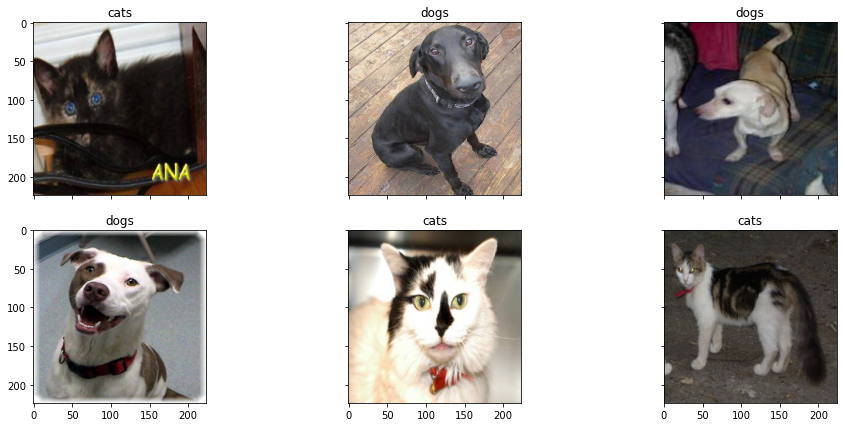

In [88]:
### PLOT SAMPLE IMAGES ###

f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax in axes.ravel():
    label = np.random.choice(os.listdir(base_path + "/train/"))
    img = np.random.choice(os.listdir(base_path + "/train/" + label))
    img = cv2.imread(base_path + "train/" + label + "/" + img)
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)

In [6]:
### GENERATOR WRAPPER TO CREATE FAKE LABEL ###

def wrap_generator(generator):
    
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        
        yield x,y

In [9]:
model = load_model('Ori_predcit_model_cat.h5')

In [135]:
### MODEL FUNCTION ###

def get_model(train=True):
    
    ae = load_model('AE_f1.h5')
    ae.compile()
    inp = Input(SHAPE)
    ae_process = GaussianNoise(0.1)(inp)
    ae_out = ae(ae_process)
    ae_out = Flatten()(ae_out)
    
    noise = Lambda(tf.zeros_like)(ae_out)
    noise = GaussianNoise(0.1)(noise)

    if train:
        x = Lambda(lambda z: tf.concat(z, axis=0))([ae_out,noise])
        x = Activation('relu')(x)
    else:
        x = ae_out
        
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(Adam(lr=1e-4), loss='binary_crossentropy')
    
    return model

# **Train only on 'CATS'**

In [10]:
### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [24]:
r"C:\Users\zxcas\Desktop\대학\캡스톤\ML_keras\임시\data\Raccoon\Raccoon\export\images".replace('\\','/')


'C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/images'

In [159]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            base_path + 'train/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            # shuffle = True,
            # seed = 33,
            classes = ['cats']
    )

test_generator = test_datagen.flow_from_directory(
            'C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            # shuffle = True,
            # seed = 33,
            classes = ['dogs','cats']
)

Found 300 images belonging to 1 classes.
Found 302 images belonging to 2 classes.


In [10]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)


es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model = get_model()
model.fit(wrap_generator(train_generator), 
steps_per_epoch=train_generator.samples//train_generator.batch_size, 
epochs=20)

Epoch 1/20
10/9 [================================] - 20s 2s/step - loss: 0.7629
Epoch 2/20
10/9 [================================] - 20s 2s/step - loss: 0.0664
Epoch 3/20
10/9 [================================] - 22s 2s/step - loss: 0.0154
Epoch 4/20
10/9 [================================] - 20s 2s/step - loss: 0.0051
Epoch 5/20
10/9 [================================] - 21s 2s/step - loss: 0.0026
Epoch 6/20
10/9 [================================] - 23s 2s/step - loss: 0.0017
Epoch 7/20
10/9 [================================] - 23s 2s/step - loss: 0.0013
Epoch 8/20
10/9 [================================] - 22s 2s/step - loss: 0.0011
Epoch 9/20
10/9 [================================] - 22s 2s/step - loss: 8.7626e-04
Epoch 10/20
10/9 [================================] - 22s 2s/step - loss: 7.5548e-04
Epoch 11/20
10/9 [================================] - 21s 2s/step - loss: 6.8356e-04
Epoch 12/20
10/9 [================================] - 21s 2s/step - loss: 5.8275e-04
Epoch 13/20
10/9 [===

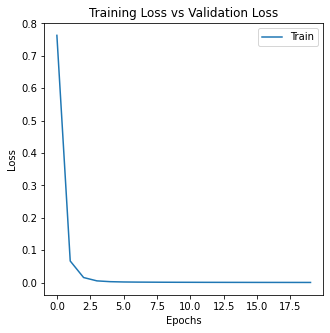

In [17]:
plt_loss_train(model.history)

In [212]:
df_lable_test = pd.DataFrame()

In [218]:
### RETRIVE TEST LABEL FROM GENERATOR ###
## yied 되는 y의 값이 반복해서 출력할 때 마다 바뀌므로 
test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

df_lable_test['3'] = label_test
df_lable_test['classes'] = test_generator.classes
df_lable_test

,0,1,2,3,classes
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,0
3,1,1,0,1,0
4,1,1,0,1,0
...,...,...,...,...,...
297,1,1,1,0,1
298,1,1,1,0,1
299,1,1,1,1,1
300,1,1,0,1,1


In [66]:
def batch_generator(generator,n):
    try:
        if n*generator.batch_size < generator.samples:
            for i in range(n):
                x,y = next(generator)
                yield x,y
    except: return 0           
samples =[]
for x,_ in batch_generator(test_generator,1):
    samples.append(x)
samples = np.array(samples).reshape(-1,
                                    test_generator.image_shape[0],
                                    test_generator.image_shape[1],
                                    test_generator.image_shape[2])
samples.shape

(64, 224, 224, 3)

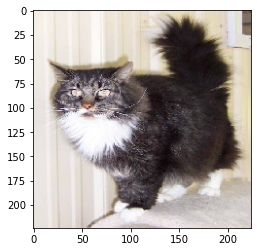

In [67]:
plt.imshow(samples[1]/255)

In [160]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [169]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = model#get_model(train=False)
#ineference_model.set_weights(model.get_weights())

In [14]:
pre = ineference_model.predict(test_generator)
pre[:5]

array([[2.5223480e-22, 1.0000000e+00],
       [8.4556228e-01, 1.5443769e-01],
       [3.4984235e-21, 1.0000000e+00],
       [6.4730149e-14, 1.0000000e+00],
       [1.9012687e-29, 1.0000000e+00]], dtype=float32)

In [170]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)

In [171]:
import pandas as pd
df = pd.DataFrame({
    'files':test_generator.filenames,
    'ground_truth': test_generator.classes,
    'predict': [p for p in pred_test]
})
print(len(df))
print(df[df['ground_truth'] != df['predict']].count())
print(df[df['ground_truth'] == df['predict']].count())
print(251/302)

302
files           47
ground_truth    47
predict         47
dtype: int64
files           255
ground_truth    255
predict         255
dtype: int64
0.8311258278145696


In [184]:
for i,d in enumerate(df['files']):
    df['files'][i] = d.replace('\\','/',) 


C:\Users\zxcas\AppData\Local\Temp\ipykernel_8328\3451030962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['files'][i] = d.replace('\\','/',)


In [185]:
df

,files,ground_truth,predict,label_test
0,dogs/dog.2011.jpg,0,1,1
1,dogs/dog.2012.jpg,0,0,1
2,dogs/dog.2016.jpg,0,1,1
3,dogs/dog.2017.jpg,0,1,0
4,dogs/dog.2021.jpg,0,1,1
...,...,...,...,...
297,cats/cat.2410.jpg,1,1,1
298,cats/cat.2411.jpg,1,1,1
299,cats/cat.2412.jpg,1,1,1
300,cats/cat.2413.jpg,1,1,1


In [180]:
print(df[df['label_test'] != df['predict']].count())
print(df[df['label_test'] == df['predict']].count())
print(287/302)

files           15
ground_truth    15
predict         15
label_test      15
dtype: int64
files           287
ground_truth    287
predict         287
label_test      287
dtype: int64
0.9503311258278145


In [ ]:
for d in df['ground_truth']:
    print(d)


C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/dogs/dog.2031.jpg
C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/cats/cat.2182.jpg
C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/cats/cat.2147.jpg
C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/cats/cat.2313.jpg
C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/cats/cat.2362.jpg
C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/cats/cat.2145.jpg


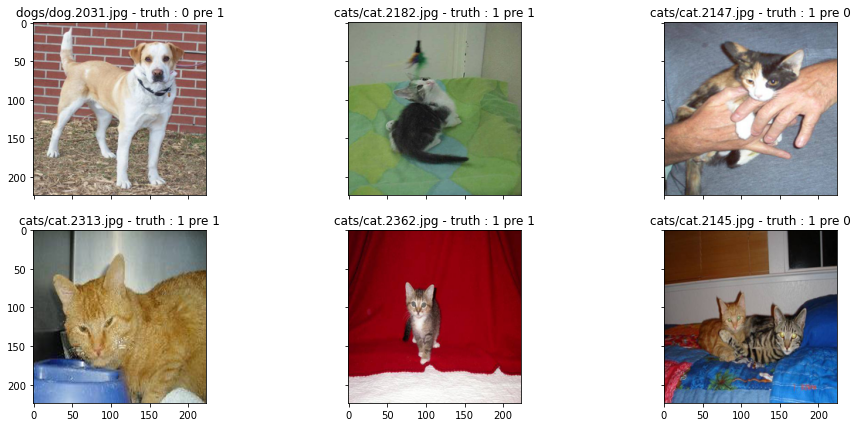

In [206]:
from PIL import Image
base = 'C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/'
f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax in axes.ravel():
    index = np.random.randint(0,len(df))
    print(base + df['files'][index])
    image = Image.open(base + df['files'][index])
    image = image.resize((224,224))
    ax.imshow(image)
    # img = cv2.imread(base + label + "/" + img)
    # img = cv2.resize(img, SHAPE[:-1])
    # ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    sub_title = "{} - truth : {} pre {}".format(df['files'][index], df['ground_truth'][index],df['predict'][index] )
    ax.set_title(sub_title)

In [174]:
### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.9503311258278145


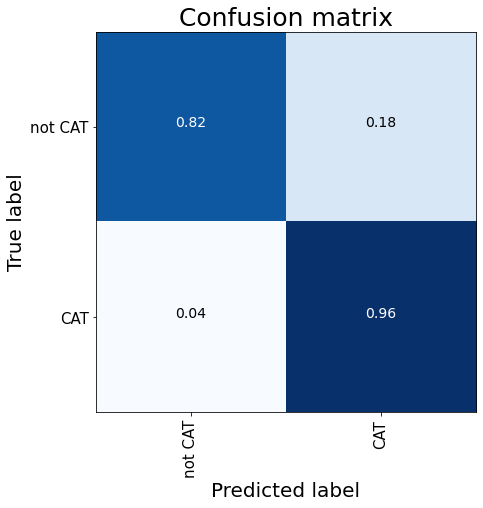

In [175]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['not CAT','CAT'])
plt.show()

# **Train only on 'DOGS'**

In [109]:
### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

#rescale 없이 47분
#52분

In [131]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            base_path + 'train/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['dogs']
    )

test_generator = test_datagen.flow_from_directory(
            base_path + 'test/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['cats','dogs']
)

Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 2 classes.


In [114]:
x,y = train_generator.next()
x

array([[[[0.21568629, 0.15294118, 0.09411766],
         [0.23529413, 0.18039216, 0.12941177],
         [0.25490198, 0.21568629, 0.1764706 ],
         ...,
         [0.19215688, 0.15686275, 0.12941177],
         [0.19215688, 0.15686275, 0.13725491],
         [0.18823531, 0.15686275, 0.14509805]],

        [[0.22352943, 0.15294118, 0.09803922],
         [0.24705884, 0.18431373, 0.13333334],
         [0.2509804 , 0.20000002, 0.16470589],
         ...,
         [0.19607845, 0.16078432, 0.13333334],
         [0.19215688, 0.15686275, 0.13725491],
         [0.19215688, 0.15294118, 0.14509805]],

        [[0.227451  , 0.15294118, 0.09411766],
         [0.25882354, 0.18823531, 0.13333334],
         [0.23137257, 0.1764706 , 0.13333334],
         ...,
         [0.20000002, 0.16470589, 0.13725491],
         [0.19607845, 0.15294118, 0.13725491],
         [0.19215688, 0.15686275, 0.13725491]],

        ...,

        [[0.13333334, 0.12941177, 0.10980393],
         [0.22352943, 0.20784315, 0.17254902]

In [136]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)  

es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples//train_generator.batch_size, epochs=20)

Epoch 1/20
62/62 [==============================] - 44s 716ms/step - loss: 0.0255
Epoch 2/20
62/62 [==============================] - 44s 708ms/step - loss: 2.3163e-06
Epoch 3/20
62/62 [==============================] - 45s 718ms/step - loss: 2.2359e-06
Epoch 4/20
62/62 [==============================] - 44s 717ms/step - loss: 2.1299e-06
Epoch 5/20
62/62 [==============================] - 44s 712ms/step - loss: 2.0469e-06
Epoch 6/20
62/62 [==============================] - 44s 717ms/step - loss: 1.9525e-06
Epoch 7/20
62/62 [==============================] - 44s 716ms/step - loss: 1.8540e-06
Epoch 8/20
62/62 [==============================] - 44s 714ms/step - loss: 1.7372e-06
Epoch 9/20
62/62 [==============================] - 45s 721ms/step - loss: 1.6620e-06
Epoch 10/20
62/62 [==============================] - 45s 722ms/step - loss: 1.5631e-06
Epoch 11/20
62/62 [==============================] - 45s 733ms/step - loss: 1.4472e-06
Epoch 12/20
62/62 [==============================] - 45s

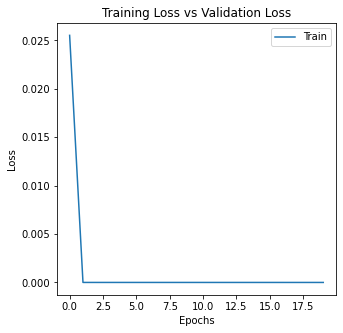

In [137]:
plt_loss_train(model.history)

In [116]:
test_generator = test_datagen.flow_from_directory(
            'C:/Users/zxcas/Desktop/대학/캡스톤/ML_keras/임시/data/Raccoon/Raccoon/export/tt/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            # shuffle = True,
            # seed = 33,
            classes = ['abnomal','dogs']
            # classes = ['dogs','cats']
)

Found 41 images belonging to 2 classes.


In [138]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

(2000,)

In [139]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)
ineference_model.set_weights(model.get_weights())

In [140]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)

In [141]:
### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.5


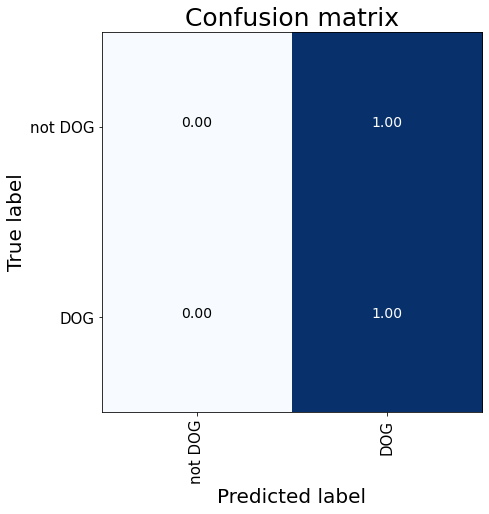

In [142]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['not DOG','DOG'])
plt.show()